In [1]:
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.core.registries import line_registry
from spectacle.modeling.fitting import LevMarFitter, LevMarLSQFitter, DynamicLevMarFitter
from spectacle.process.lsf import LSF

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from uncertainties import unumpy as unp

INFO:root:Added misty to custom loaders.
INFO:root:Added my-format to custom loaders.


In [2]:
%matplotlib notebook
# plt.rcParams["figure.figsize"] = [16, 8]

# Identify and parameterize real data
This is an example notebook of taking some real data and fitting an absorption feature. It is very basic, and uses all the default settings.

## Load data
Load the data. The fitter currently assumes that all data has been normalized to 1.

In [3]:
# Set the line list to use
line_registry.read("/Users/nearl/projects/spectacle/spectacle/data/line_list/atoms.ecsv")

In [4]:
# Load real data
with fits.open("/Users/nearl/projects/hst_proposal/QSOALS/3C066A/3C066A_coadd_FUVM_final_all.fits") as hdulist:
    disp, flux, uncert, dq = hdulist[1].data['WAVE'], hdulist[1].data['FLUX'], \
                             hdulist[1].data['ERROR'], hdulist[1].data['DQ']

In [5]:
# Create a mask and apply it since we don't really care about the entire spectrum
# mask = [(disp > 1276) & (disp < 1283)]
mask = [(disp > 1250) & (disp < 1300)]

flux = flux[mask]
disp = disp[mask]
uncert = uncert[mask]

# Currently, the fitting assumes that the data is normalized to 1.0
tmp_flux = unp.uarray(flux, uncert)
tmp_flux /= np.median(tmp_flux)
flux, uncert = unp.nominal_values(tmp_flux), unp.std_devs(tmp_flux)

# Create spectrum object
spectrum = Spectrum1D(flux, dispersion=disp, uncertainty=uncert)

## Find some lines and create Absorption1D model

Note that `strict=True` means that only lines that exist in the line list will be found.

In [6]:
found_lines = spectrum.find_lines(threshold=0.5/max(1-spectrum.data),
                                  min_dist=10,
                                  smooth=True,
                                  interpolate=True,
                                  defaults=dict(
                                      fixed={
                                          'lambda_0': True,
                                          'delta_v': True,
                                          'delta_lambda': False}))
spec_mod = Absorption1D(lines=found_lines)

/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/PeakUtils-1.1.0-py3.6.egg/peakutils/peak.py:216: UserWarning: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
INFO:root:Found 10 lines.
INFO:root:Found SII1251 (1250.584) at 1250.5372177921236. Strict is False.
INFO:root:Found SII1254 (1253.811) at 1253.7556255489587. Strict is False.
INFO:root:Found SII1260 (1259.519) at 1259.4451327599586. Strict is False.
INFO:root:Found SiII1260 (1260.4221) at 1260.3419027231635. Strict is False.
INFO:root:Found CI1277 (1277.245) at 1277.2310703635217. Strict is False.
INFO:root:Found CI1277_1 (1277.245) at 1277.9783786661924. Strict is False.
INFO:root:Found TiIII1299 (1298.697) at 1299.9990633182229. Strict is False.
INFO:root:Found CI1280 (1280.1352) at 1282.2729103788733. Strict is False.
INFO:root:Found TiIII1299_1 (1298.697) at 1297.6475331924855. Strict is False.
INFO:root:Found TiIII1299_2 (1298.697) at 1297.8368512958289. Strict is False.
I

<IPython.core.display.Javascript object>


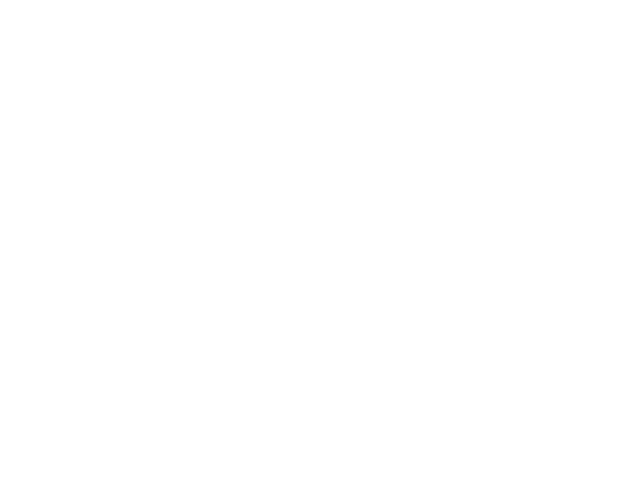

In [7]:
%matplotlib notebook
# Check out the results. Calling the mode with a dispersion array returns a `Spectrum1D` object
y = spec_mod(spectrum.dispersion)

# Plot the results
f, (ax1) = plt.subplots()

ax1.plot(y.data)

## Create `Fitter`
The `Fitter` object encapsulates the method of fitting, along with the line identifying and detrending routines. Certain parameters, like the distance between identified lines, and the noise level can also be set.

In [8]:
# Create a fitter. The default fitting routine is a LevMarLSQ.
fitter = DynamicLevMarFitter()

fit_spec_mod = fitter(spec_mod, spectrum.dispersion, spectrum.data, maxiter=200, initialize=False)#, guess_lines=False)
fitter.fit_info['message']

/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/astropy/units/quantity.py:957: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/astropy/units/quantity.py:974: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/nearl/projects/spectacle/spectacle/core/profiles.py:90: RuntimeWarning: invalid value encountered in multiply
  return special.wofz(x + 1j * y).real
/Users/nearl/projects/spectacle/spectacle/core/spectra.py:119: RuntimeWarning: invalid value encountered in less
  data[data < 0.0] = 0.0
INFO:root:Fit result is below chi squared of 0.1 (82956984952.54674).
INFO:root:Fit improved with addition of line at 1297.5678203068674:
	Chi squared: 82956984952.54674 -> 888831774.1814345.
INFO:root:Fit improved with addition of line at 1250.547181902826:
	Chi squared: 888831774.1814345 -> 443

'The relative error between two consecutive iterates is at most 0.000000'

<IPython.core.display.Javascript object>


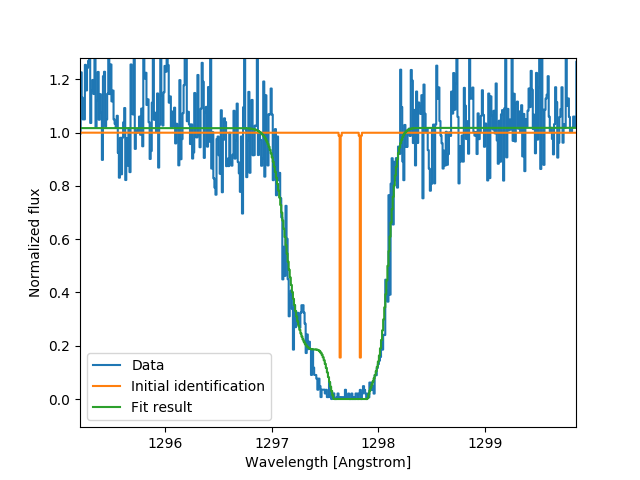

In [9]:
%matplotlib notebook
# Call the absorption model with a dispersion array to get a `Spectrum1D` object
fit_y = fit_spec_mod(spectrum.dispersion)

# Plot the results
f, (ax1) = plt.subplots()

ax1.step(spectrum.dispersion, spectrum.data, label="Data")
ax1.step(y.dispersion, y.data, label="Initial identification")
ax1.step(fit_y.dispersion, fit_y.data, label="Fit result")

ax1.set_xlabel("Wavelength [Angstrom]")
ax1.set_ylabel("Normalized flux")

plt.legend(loc=0)

Let's get some first- and second-order information out of this.

In [10]:
print("Equivalent width: {}".format(fit_y.equivalent_width()))
print("Centroid: {}".format(fit_y.centroid(1260)))

Equivalent width: (2.528798090058262, 0.0)
Centroid: (array(1260.4695463801256), array(0.0))


In [11]:
print(fit_spec_mod["TiIII1299"])
fit_y.equivalent_width(fit_spec_mod["TiIII1299"].lambda_0.value)

Model: Line
Name: TiIII1299
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       lambda_0   f_value    gamma    ... column_density delta_v   delta_lambda 
    ------------- ------- ----------- ... -------------- ------- ---------------
    1299.99906332  0.0964 635000000.0 ...            0.0     0.0 0.0329210973572


(2.528798090058262, 0.0)